In [1]:
!pip install "numpy==1.23.5" --user

GPU Detected: NVIDIA A100-SXM4-40GB

Starting CuPy RawKernel Benchmark (A100)...
Grid Size       | Time (s)        | MNodes/s       
------------------------------------------------------------
1000x1000        | 0.00122         | 81984.05       
2000x2000        | 0.00503         | 79475.21       
4000x4000        | 0.01930         | 82896.50       
8000x8000        | 0.07586         | 84368.03       


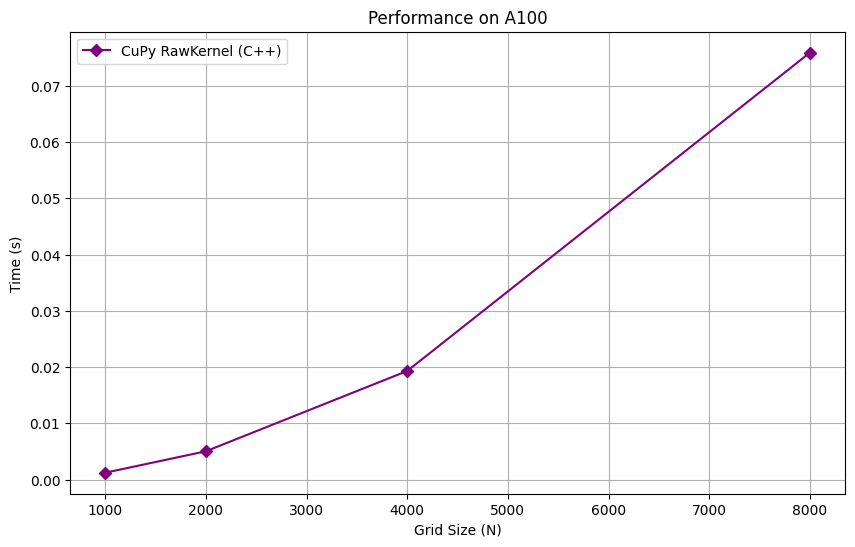

In [2]:
import sys
import os
import site

user_site = site.getusersitepackages()
if user_site not in sys.path:
    sys.path.insert(0, user_site)

import cupy as cp
import numpy as np
import time
import math
import matplotlib.pyplot as plt

# ==========================================
# 1. CUDA C++ Kernel
# ==========================================
cuda_source = r'''
extern "C" __global__
void poisson_shared_kernel(const float* u_in, float* u_out, const float* b, int N, int M) {
    // Static Shared Memory: 16x16 block + 2 halo = 18x18
    __shared__ float s_u[18][18];

    int tx = threadIdx.x;
    int ty = threadIdx.y;
    
    // Global coordinates
    int x = blockIdx.x * blockDim.x + tx;
    int y = blockIdx.y * blockDim.y + ty;
    
    // Linear index for global memory
    int idx = y * M + x;
    
    // Shared memory coordinates (with halo offset)
    int sx = tx + 1;
    int sy = ty + 1;

    // --- 1. Load Data into Shared Memory ---
    s_u[sy][sx] = 0.0f;
    if (y < N && x < M) {
        s_u[sy][sx] = u_in[idx];
    }

    // --- 2. Halo Loading ---
    // Top
    if (ty == 0 && y > 0) s_u[0][sx] = u_in[(y - 1) * M + x];
    // Bottom
    if (ty == 15 && y < N - 1) s_u[17][sx] = u_in[(y + 1) * M + x];
    // Left
    if (tx == 0 && x > 0) s_u[sy][0] = u_in[y * M + (x - 1)];
    // Right
    if (tx == 15 && x < M - 1) s_u[sy][17] = u_in[y * M + (x + 1)];

    __syncthreads();

    // --- 3. Computation ---
    if (y > 0 && y < N - 1 && x > 0 && x < M - 1) {
        float val = s_u[sy - 1][sx] + s_u[sy + 1][sx] + s_u[sy][sx - 1] + s_u[sy][sx + 1];
        u_out[idx] = 0.25f * (val - b[idx]);
    }
}
'''

# Compile the kernel
poisson_kernel = cp.RawKernel(cuda_source, 'poisson_shared_kernel')

# ==========================================
# 2. Benchmark Logic
# ==========================================
def run_benchmark():
    try:
        device_name = cp.cuda.runtime.getDeviceProperties(0)['name'].decode()
        print(f"GPU Detected: {device_name}")
    except:
        print("Error: CuPy cannot connect to GPU.")
        return

    print("\nStarting CuPy RawKernel Benchmark (A100)...")
    
    grid_sizes = [1000, 2000, 4000, 8000]
    iters = 100
    TPB = 16
    times = []
    
    print(f"{'Grid Size':<15} | {'Time (s)':<15} | {'MNodes/s':<15}")
    print("-" * 60)

    for n in grid_sizes:
        try:
            # Prepare data on GPU directly
            u = cp.zeros((n, n), dtype=cp.float32)
            b = cp.random.rand(n, n, dtype=cp.float32)
            u_out = cp.zeros_like(u)
            
            # Grid Configuration
            block_dim = (TPB, TPB)
            grid_x = int(math.ceil(n / TPB))
            grid_y = int(math.ceil(n / TPB))
            grid_dim = (grid_x, grid_y)
            
            # Warmup
            poisson_kernel(grid_dim, block_dim, (u, u_out, b, n, n))
            cp.cuda.Stream.null.synchronize()
            
            # Timing
            t0 = time.time()
            for i in range(iters):
                if i % 2 == 0:
                    poisson_kernel(grid_dim, block_dim, (u, u_out, b, n, n))
                else:
                    poisson_kernel(grid_dim, block_dim, (u_out, u, b, n, n))
            
            cp.cuda.Stream.null.synchronize()
            t1 = time.time()
            
            total_time = t1 - t0
            mnodes = (n * n * iters) / total_time / 1e6
            print(f"{n}x{n:<11} | {total_time:<15.5f} | {mnodes:<15.2f}")
            times.append(total_time)
            
            # Clean up
            del u, b, u_out
            cp.get_default_memory_pool().free_all_blocks()
            
        except Exception as e:
            print(f"{n}x{n} Error: {e}")
            times.append(0)

    # Plot
    if sum(times) > 0:
        plt.figure(figsize=(10, 6))
        plt.plot(grid_sizes, times, 'D-', color='purple', label='CuPy RawKernel (C++)')
        plt.xlabel('Grid Size (N)')
        plt.ylabel('Time (s)')
        plt.title('Performance on A100')
        plt.grid(True)
        plt.legend()
        plt.show()

if __name__ == "__main__":
    run_benchmark()

## 3D Poisson (Jacobi) Benchmark (CuPy RawKernel)

This section adds a 3D (7-point stencil) Jacobi update benchmark on GPU.
- Updates **interior voxels only** (boundary fixed).
- Uses **ping-pong buffers**.
- Reports **Time(s)** and **Throughput (GNodes/s)** where `GNodes/s = N^3 * iters / time / 1e9`.


In [3]:

# ==========================================
# 3D Poisson (Jacobi) RawKernel Benchmark
# ==========================================
import cupy as cp
import time, math

cuda_source_3d = r'''
extern "C" __global__
void poisson3d_kernel(const float* u_in, float* u_out, const float* b, int N) {
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;
    int z = blockIdx.z * blockDim.z + threadIdx.z;

    // interior only (fixed boundary)
    if (x <= 0 || x >= N-1 || y <= 0 || y >= N-1 || z <= 0 || z >= N-1) return;

    int stride_y = N;
    int stride_z = N * N;
    int idx = z * stride_z + y * stride_y + x;

    float xm = u_in[idx - 1];
    float xp = u_in[idx + 1];
    float ym = u_in[idx - stride_y];
    float yp = u_in[idx + stride_y];
    float zm = u_in[idx - stride_z];
    float zp = u_in[idx + stride_z];

    float val = xm + xp + ym + yp + zm + zp;
    u_out[idx] = (1.0f/6.0f) * (val - b[idx]);
}
'''
poisson3d = cp.RawKernel(cuda_source_3d, "poisson3d_kernel")

def bench_cupy_3d(n=256, iters=100, block=(8,8,8)):
    u  = cp.zeros((n, n, n), dtype=cp.float32)
    b  = cp.random.rand(n, n, n, dtype=cp.float32)
    u2 = cp.zeros_like(u)

    grid = (math.ceil(n/block[0]), math.ceil(n/block[1]), math.ceil(n/block[2]))

    # warmup (also triggers JIT compilation / context init)
    poisson3d(grid, block, (u, u2, b, n))
    cp.cuda.Stream.null.synchronize()

    t0 = time.time()
    for i in range(iters):
        if i % 2 == 0:
            poisson3d(grid, block, (u,  u2, b, n))
        else:
            poisson3d(grid, block, (u2, u,  b, n))
    cp.cuda.Stream.null.synchronize()
    t1 = time.time()

    total = t1 - t0
    gnodes = (n**3 * iters) / total / 1e9
    return total, gnodes

# ---- Run a small scaling sweep (keep sizes modest for 3D memory) ----
try:
    device_name = cp.cuda.runtime.getDeviceProperties(0)['name'].decode()
    print(f"GPU Detected: {device_name}")
except Exception as e:
    print("Error: CuPy cannot connect to GPU.", e)
    raise

sizes = [128, 192, 256]   # adjust if you want larger (e.g., 320/384) and have memory
iters = 100

print("\nStarting 3D CuPy RawKernel Benchmark...")
print(f"{'N^3':<12} | {'Time (s)':<12} | {'GNodes/s':<12}")
print("-"*45)
for n in sizes:
    t, gn = bench_cupy_3d(n=n, iters=iters, block=(8,8,8))
    print(f"{n}^3{'':<7} | {t:<12.6f} | {gn:<12.2f}")


GPU Detected: NVIDIA A100-SXM4-40GB

Starting 3D CuPy RawKernel Benchmark...
N^3          | Time (s)     | GNodes/s    
---------------------------------------------
128^3        | 0.002781     | 75.41       
192^3        | 0.008752     | 80.88       
256^3        | 0.019163     | 87.55       
